In [114]:
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, TimeSeriesSplit, KFold, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from lpi_python import lpi_distance, lpi_mean
import numpy as np
import math
import matplotlib.pyplot as plt
import csv
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder

In [115]:
data = pd.read_csv('data1.csv', parse_dates=True)
data['Unnamed: 0'] = pd.to_datetime(data['Unnamed: 0'])
data["month_of_year"] = data['Unnamed: 0'].dt.month
data["hour_of_day"] = data['Unnamed: 0'].dt.hour
data["day_of_week"] = data['Unnamed: 0'].dt.dayofweek

In [116]:
# For AKNN
# 02/01/2015 to 30/11/2016
ini_data = data[18:16794]
# 30/11/2016
prev_day_data = data[16770:16794]
# 01/12/2016
last_day_data = data[16794:16818]

y_test_pv_01_12 = last_day_data['PV']
y_test_wind_01_12 = last_day_data['Wind']

generation_pv_30_11 = np.array(prev_day_data['PV'])
generation_wind_30_11 = np.array(prev_day_data['Wind'])

y_train_pv = np.array(ini_data['PV'])
y_train_wind = np.array(ini_data['Wind'])

chunks_pv = [y_train_pv[x:x + 24] for x in range(0, len(y_train_pv), 24)]
chunks_wind = [y_train_wind[x:x + 24] for x in range(0, len(y_train_wind), 24)]

time_last_day = np.array(last_day_data['Unnamed: 0'])

In [117]:
def aknn(load, chunks):
    x_generation = []
    dist = []
    d1_dist = dict()
    for x in chunks:
        x_generation.append(x)
        d = lpi_distance(load, x)
        dist.append(d)
        d1_dist.update({d:x})
    sorted_dict = dict()
    for key in sorted(d1_dist.keys()):
        sorted_dict.update({key: d1_dist[key]})
    d1_generation = []
    for key in sorted_dict.keys():
        d1_generation.append(sorted_dict[key])
    m = lpi_mean(d1_generation[:6])
    return m


def prediction(generation, chunks):
    aknn_predicted_load_school = [aknn(generation, chunks)]
    plot_values = []
    for pred in aknn_predicted_load_school:
        for l in pred:
            plot_values.append(l)
    return plot_values

In [118]:
def step_graph(prediction, actual, ylabl, xlabl):
    hour = []
    for i in range(24):
        hour.append(i)
    plt.step(hour, prediction, label='Predicted')
    plt.step(hour, actual.values, label='Actual')
    plt.ylabel(ylabl)
    plt.xticks([0, 5, 10, 15, 20],
               ['00:00', '05:00', '10:00', '15:00', '20:00'])
    plt.xlabel(xlabl)
    plt.legend()
    return plt.show()


def continuous_graph(prediction, actual, ylabl, xlabl):
    plt.plot(prediction, label='Predicted')
    plt.plot(actual.values, label='Actual')
    plt.ylabel(ylabl)
    plt.xticks([0, 5, 10, 15, 20],
               ['00:00', '05:00', '10:00', '15:00', '20:00'])
    plt.xlabel(xlabl)
    plt.legend()
    return plt.show()

def rmse(y_true, y_pred):
    '''Root Mean Square Error'''
    return np.sqrt(np.average((y_true - y_pred) ** 2))
def mae(y_true, y_pred):
    '''Mean Absolute Error'''
    return np.average(np.abs(y_pred - y_true))

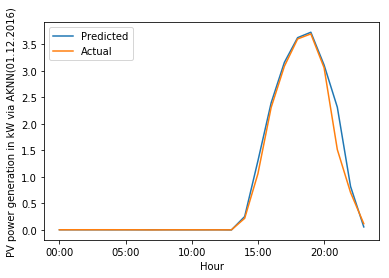

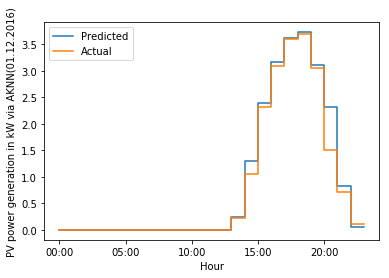

RMSE: 0.17
MAE: 0.06
NRMSE: 0.22


In [119]:
# AKNN PV
plot_values_pv = prediction(generation_pv_30_11, chunks_pv)
continuous_graph(plot_values_pv, y_test_pv_01_12, 'PV power generation in kW via AKNN(01.12.2016)', 'Hour')
step_graph(plot_values_pv, y_test_pv_01_12, 'PV power generation in kW via AKNN(01.12.2016)', 'Hour')
print("RMSE: {:.2f}" .format(rmse(y_test_pv_01_12, plot_values_pv)))
print("MAE: {:.2f}" .format(mae(y_test_pv_01_12, plot_values_pv)))
mean_pv = np.mean(y_test_pv_01_12)
nrmse_pv_aknn = rmse(y_test_pv_01_12, plot_values_pv) / mean_pv
print("NRMSE: {:.2f}" .format(nrmse_pv_aknn))

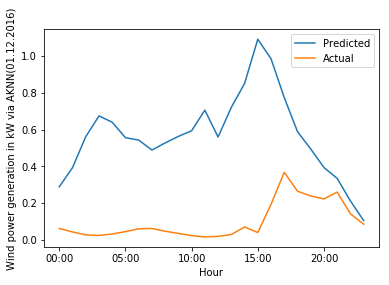

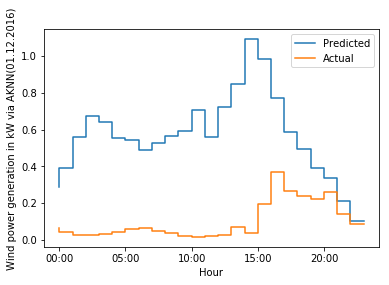

RMSE: 0.53
MAE: 0.47
NRMSE: 5.28


In [120]:
# AKNN Wind
plot_values_wind = prediction(generation_wind_30_11, chunks_wind)
continuous_graph(plot_values_wind, y_test_wind_01_12, 'Wind power generation in kW via AKNN(01.12.2016)', 'Hour')
step_graph(plot_values_wind, y_test_wind_01_12, 'Wind power generation in kW via AKNN(01.12.2016)', 'Hour')

print("RMSE: {:.2f}" .format(rmse(y_test_wind_01_12, plot_values_wind)))
print("MAE: {:.2f}" .format(mae(y_test_wind_01_12, plot_values_wind)))
mean_wind = np.mean(y_test_wind_01_12)
nrmse_wind_aknn = rmse(y_test_wind_01_12, plot_values_wind) / mean_wind
print("NRMSE: {:.2f}" .format(nrmse_wind_aknn))

In [121]:
# 02/01/2015 to 01/12/2016
data_till_01_12 = data[18:16818]
load_wind = data_till_01_12.loc[:,'Wind']
load_pv = data_till_01_12.loc[:,'PV']
X_wind = pd.DataFrame(index=data_till_01_12.index)
X_pv = pd.DataFrame(index=data_till_01_12.index)

In [122]:
lags = [1,2,3,4,5,6,24,48,168]
for lag in lags:
    X_wind.loc[:,"lag_"+str(lag)] = load_wind.shift(lag)
for lag in lags:
    X_pv.loc[:,"lag_"+str(lag)] = load_pv.shift(lag)

In [123]:
X_wind.loc[:,"HoD"] = data_till_01_12["hour_of_day"]
X_wind.loc[:,"DoW"] = data_till_01_12["day_of_week"]
X_wind.loc[:,"MoY"] = data_till_01_12["month_of_year"]
X_wind.loc[:,"Temperature"] = data_till_01_12["temperature"]

X_pv.loc[:,"HoD"] = data_till_01_12["hour_of_day"]
X_pv.loc[:,"DoW"] = data_till_01_12["day_of_week"]
X_pv.loc[:,"MoY"] = data_till_01_12["month_of_year"]
X_pv.loc[:,"Temperature"] = data_till_01_12["temperature"]

# One-hot encoding
X_wind = pd.get_dummies(X_wind, columns=["HoD"])
X_wind = pd.get_dummies(X_wind, columns=["DoW"])
X_wind = pd.get_dummies(X_wind, columns=["MoY"])

X_pv = pd.get_dummies(X_pv, columns=["HoD"])
X_pv = pd.get_dummies(X_pv, columns=["DoW"])
X_pv = pd.get_dummies(X_pv, columns=["MoY"])

Y_wind = data_till_01_12['Wind']
Y_pv = data_till_01_12['PV']

In [124]:
# Train/Test Split
X_train_wind, X_test_wind, y_train_wind, y_test_wind = train_test_split(X_wind.iloc[168:,:], Y_wind.iloc[168:], test_size=0.0014, shuffle=False)
X_train_pv, X_test_pv, y_train_pv, y_test_pv = train_test_split(X_pv.iloc[168:,:], Y_pv.iloc[168:], test_size=0.0014, shuffle=False)

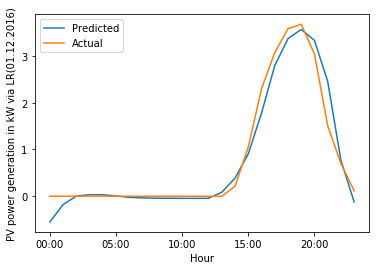

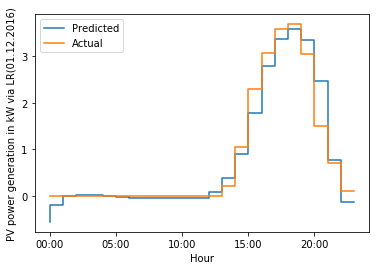

RMSE: 0.28
MAE: 0.17
NRMSE: 0.35


In [129]:
# Linear regression PV
lr_pv = LinearRegression()
lr_pv.fit(X_train_pv, y_train_pv)
lr_pv_hat = lr_pv.predict(X_test_pv)

continuous_graph(lr_pv_hat, y_test_pv, 'PV power generation in kW via LR(01.12.2016)', 'Hour')
step_graph(lr_pv_hat, y_test_pv, 'PV power generation in kW via LR(01.12.2016)', 'Hour')

print("RMSE: {:.2f}" .format(rmse(y_test_pv, lr_pv_hat)))
print("MAE: {:.2f}" .format(mae(y_test_pv, lr_pv_hat)))
nrmse_pv_lr = rmse(y_test_pv, lr_pv_hat) / mean_pv
print("NRMSE: {:.2f}" .format(nrmse_pv_lr))

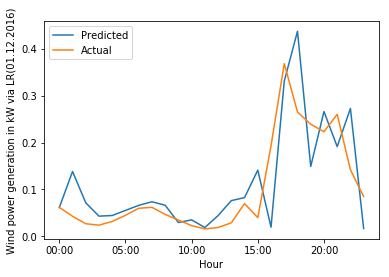

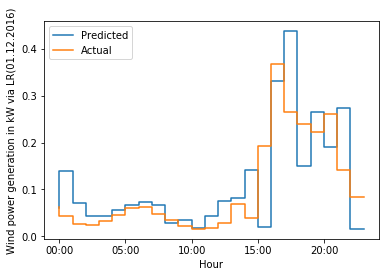

RMSE: 0.07
MAE: 0.05
NRMSE: 0.71


In [130]:
# Linear regression Wind
lr_wind = LinearRegression()
lr_wind.fit(X_train_wind, y_train_wind)
lr_wind_hat = lr_wind.predict(X_test_wind)

continuous_graph(lr_wind_hat, y_test_wind, 'Wind power generation in kW via LR(01.12.2016)', 'Hour')
step_graph(lr_wind_hat, y_test_wind, 'Wind power generation in kW via LR(01.12.2016)', 'Hour')

print("RMSE: {:.2f}" .format(rmse(y_test_wind, lr_wind_hat)))
print("MAE: {:.2f}" .format(mae(y_test_wind, lr_wind_hat)))
nrmse_wind_lr = rmse(y_test_wind, lr_wind_hat) / mean_wind
print("NRMSE: {:.2f}" .format(nrmse_wind_lr))

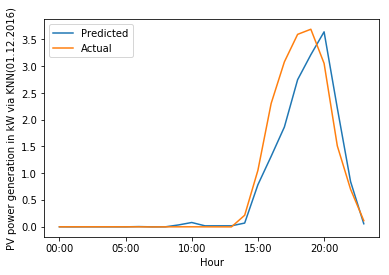

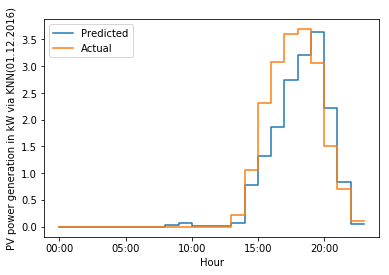

RMSE: 0.43
MAE: 0.23
NRMSE: 0.53


In [131]:
# KNN PV
knn_pv = KNeighborsRegressor(n_neighbors=24)
knn_pv.fit(X_train_pv, y_train_pv)
y_pv_hat = knn_pv.predict(X_test_pv)

continuous_graph(y_pv_hat, y_test_pv, 'PV power generation in kW via KNN(01.12.2016)', 'Hour')
step_graph(y_pv_hat, y_test_pv, 'PV power generation in kW via KNN(01.12.2016)', 'Hour')

print("RMSE: {:.2f}" .format(rmse(y_test_pv, y_pv_hat)))
print("MAE: {:.2f}" .format(mae(y_test_pv, y_pv_hat)))
nrmse_pv_knn = rmse(y_test_pv, y_pv_hat) / mean_pv
print("NRMSE: {:.2f}" .format(nrmse_pv_knn))

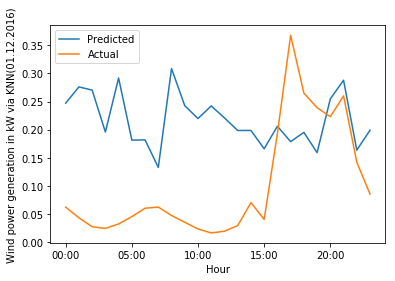

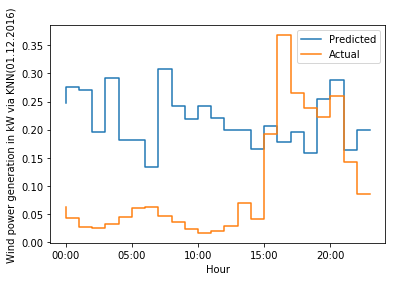

RMSE: 0.16
MAE: 0.15
NRMSE: 1.64


In [128]:
# KNN Wind
knn_wind = KNeighborsRegressor(n_neighbors=24)
knn_wind.fit(X_train_wind, y_train_wind)
y_wind_hat = knn_wind.predict(X_test_wind)

continuous_graph(y_wind_hat, y_test_wind, 'Wind power generation in kW via KNN(01.12.2016)', 'Hour')
step_graph(y_wind_hat, y_test_wind, 'Wind power generation in kW via KNN(01.12.2016)', 'Hour')

print("RMSE: {:.2f}" .format(rmse(y_test_wind, y_wind_hat)))
print("MAE: {:.2f}" .format(mae(y_test_wind, y_wind_hat)))
nrmse_wind_knn = rmse(y_test_wind, y_wind_hat) / mean_wind
print("NRMSE: {:.2f}" .format(nrmse_wind_knn))

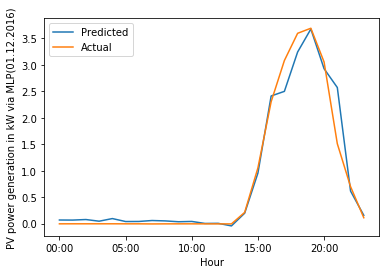

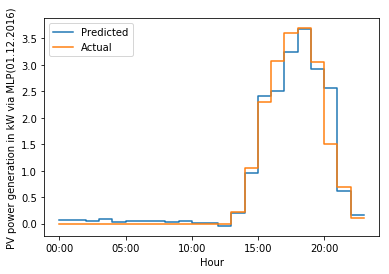

RMSE: 0.26
MAE: 0.13
NRMSE: 0.33


In [140]:
# MLP PV
mlp_pv = MLPRegressor()
mlp_pv.fit(X_train_pv, y_train_pv)
m_pv_hat = mlp_pv.predict(X_test_pv)

continuous_graph(m_pv_hat, y_test_pv, 'PV power generation in kW via MLP(01.12.2016)', 'Hour')
step_graph(m_pv_hat, y_test_pv, 'PV power generation in kW via MLP(01.12.2016)', 'Hour')

print("RMSE: {:.2f}" .format(rmse(y_test_pv, m_pv_hat)))
print("MAE: {:.2f}" .format(mae(y_test_pv, m_pv_hat)))
nrmse_pv_mlp = rmse(y_test_pv, m_pv_hat) / mean_pv
print("NRMSE: {:.2f}" .format(nrmse_pv_mlp))

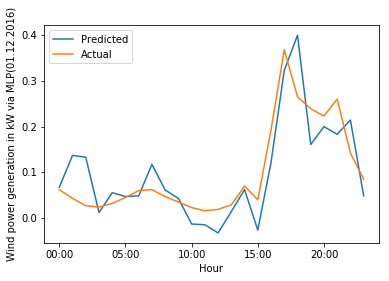

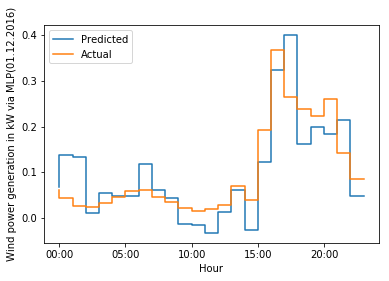

RMSE: 0.06
MAE: 0.04
NRMSE: 0.57


In [137]:
# MLP Wind
mlp_wind = MLPRegressor()
mlp_wind.fit(X_train_wind, y_train_wind)
m_wind_hat = mlp_wind.predict(X_test_wind)
continuous_graph(m_wind_hat, y_test_wind, 'Wind power generation in kW via MLP(01.12.2016)', 'Hour')
step_graph(m_wind_hat, y_test_wind, 'Wind power generation in kW via MLP(01.12.2016)', 'Hour')

print("RMSE: {:.2f}" .format(rmse(y_test_wind, m_wind_hat)))
print("MAE: {:.2f}" .format(mae(y_test_wind, m_wind_hat)))
nrmse_wind_mlp = rmse(y_test_wind, m_wind_hat) / mean_wind
print("NRMSE: {:.2f}" .format(nrmse_wind_mlp))

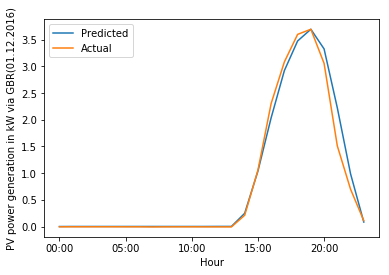

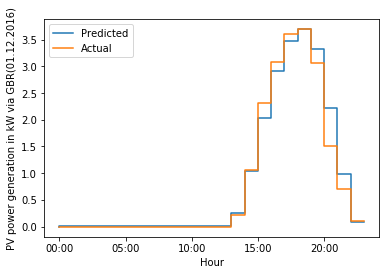

RMSE: 0.18
MAE: 0.08
NRMSE: 0.22


In [138]:
# Gradient boosting regression PV
params = {'n_estimators': 500, 'max_depth': 6, 'min_samples_split': 2, 'learning_rate': 0.01, 'loss': 'ls'}
gbr_pv = GradientBoostingRegressor(**params)
gbr_pv.fit(X_train_pv, y_train_pv)
gbr_pv_hat = gbr_pv.predict(X_test_pv)

continuous_graph(gbr_pv_hat, y_test_pv, 'PV power generation in kW via GBR(01.12.2016)', 'Hour')
step_graph(gbr_pv_hat, y_test_pv, 'PV power generation in kW via GBR(01.12.2016)', 'Hour')

print("RMSE: {:.2f}" .format(rmse(y_test_pv, gbr_pv_hat)))
print("MAE: {:.2f}" .format(mae(y_test_pv, gbr_pv_hat)))
nrmse_pv_gbr = rmse(y_test_pv, gbr_pv_hat) / mean_pv
print("NRMSE: {:.2f}" .format(nrmse_pv_gbr))

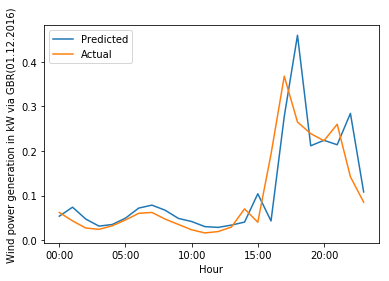

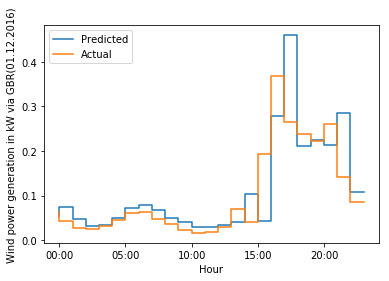

RMSE: 0.06
MAE: 0.04
NRMSE: 0.64


In [141]:
# Gradient boosting regression Wind
gbr_wind = GradientBoostingRegressor(**params)
gbr_wind.fit(X_train_wind, y_train_wind)
gbr_wind_hat = gbr_wind.predict(X_test_wind)

continuous_graph(gbr_wind_hat, y_test_wind, 'Wind power generation in kW via GBR(01.12.2016)', 'Hour')
step_graph(gbr_wind_hat, y_test_wind, 'Wind power generation in kW via GBR(01.12.2016)', 'Hour')

print("RMSE: {:.2f}" .format(rmse(y_test_wind, gbr_wind_hat)))
print("MAE: {:.2f}" .format(mae(y_test_wind, gbr_wind_hat)))
nrmse_wind_gbr = rmse(y_test_wind, gbr_wind_hat) / mean_wind
print("NRMSE: {:.2f}" .format(nrmse_wind_gbr))

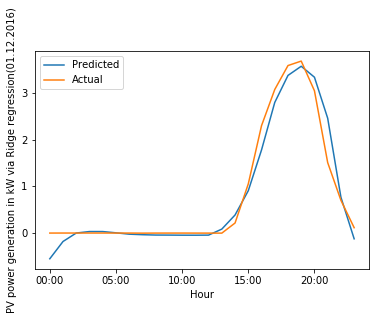

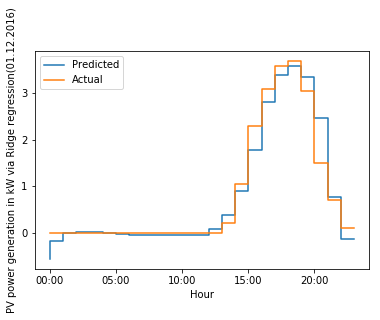

RMSE: 0.28
MAE: 0.17
NRMSE: 0.35


In [142]:
# Ridge PV
r_pv = Ridge()
r_pv.fit(X_train_pv, y_train_pv)
r_pv_hat = r_pv.predict(X_test_pv)
continuous_graph(r_pv_hat, y_test_pv, 'PV power generation in kW via Ridge regression(01.12.2016)',
                 'Hour')
step_graph(r_pv_hat, y_test_pv, 'PV power generation in kW via Ridge regression(01.12.2016)', 'Hour')

print("RMSE: {:.2f}" .format(rmse(y_test_pv, r_pv_hat)))
print("MAE: {:.2f}" .format(mae(y_test_pv, r_pv_hat)))
nrmse_pv_ridge = rmse(y_test_pv, r_pv_hat) / mean_pv
print("NRMSE: {:.2f}" .format(nrmse_pv_ridge))

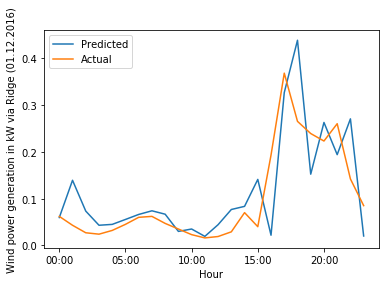

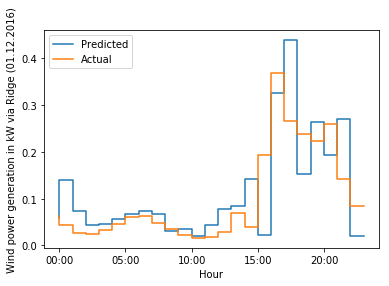

RMSE: 0.07
MAE: 0.05
NRMSE: 0.71


In [143]:
# Ridge Wind
r_wind = Ridge()
r_wind.fit(X_train_wind, y_train_wind)
r_wind_hat = r_wind.predict(X_test_wind)

continuous_graph(r_wind_hat, y_test_wind, 'Wind power generation in kW via Ridge (01.12.2016)', 'Hour')
step_graph(r_wind_hat, y_test_wind, 'Wind power generation in kW via Ridge (01.12.2016)', 'Hour')

print("RMSE: {:.2f}" .format(rmse(y_test_wind, r_wind_hat)))
print("MAE: {:.2f}" .format(mae(y_test_wind, r_wind_hat)))
nrmse_wind_ridge = rmse(y_test_wind, r_wind_hat) / mean_wind
print("NRMSE: {:.2f}" .format(nrmse_wind_ridge))

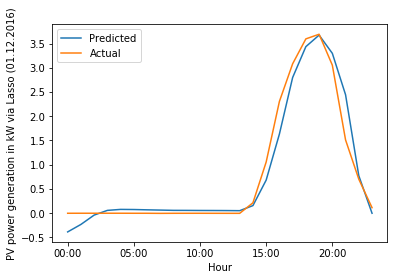

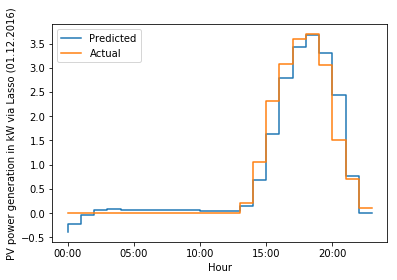

RMSE: 0.28
MAE: 0.18
NRMSE: 0.35


In [144]:
# Lasso PV
lasso_pv = Lasso(alpha=0.01)
lasso_pv.fit(X_train_pv, y_train_pv)
lasso_pv_hat = lasso_pv.predict(X_test_pv)

continuous_graph(lasso_pv_hat, y_test_pv, 'PV power generation in kW via Lasso (01.12.2016)', 'Hour')
step_graph(lasso_pv_hat, y_test_pv, 'PV power generation in kW via Lasso (01.12.2016)', 'Hour')

print("RMSE: {:.2f}" .format(rmse(y_test_pv, lasso_pv_hat)))
print("MAE: {:.2f}" .format(mae(y_test_pv, lasso_pv_hat)))
nrmse_pv_lasso = rmse(y_test_pv, lasso_pv_hat) / mean_pv
print("NRMSE: {:.2f}" .format(nrmse_pv_lasso))

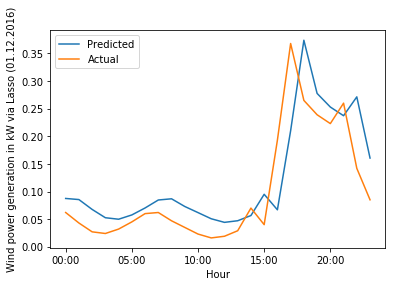

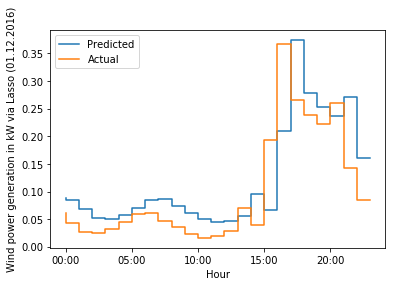

RMSE: 0.06
MAE: 0.05
NRMSE: 0.62


In [145]:
# Lasso Wind
lasso_wind = Lasso(alpha=0.01)
lasso_wind.fit(X_train_wind, y_train_wind)
lasso_wind_hat = lasso_wind.predict(X_test_wind)

continuous_graph(lasso_wind_hat, y_test_wind, 'Wind power generation in kW via Lasso (01.12.2016)',
                 'Hour')
step_graph(lasso_wind_hat, y_test_wind, 'Wind power generation in kW via Lasso (01.12.2016)', 'Hour')

print("RMSE: {:.2f}" .format(rmse(y_test_wind, lasso_wind_hat)))
print("MAE: {:.2f}" .format(mae(y_test_wind, lasso_wind_hat)))
nrmse_wind_lasso = rmse(y_test_wind, lasso_wind_hat) / mean_wind
print("NRMSE: {:.2f}" .format(nrmse_wind_lasso))

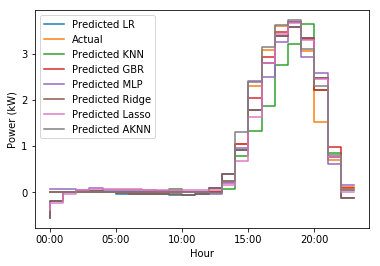

In [146]:
# Comparison PV using step graph
hour = []
for i in range(24):
    hour.append(i)
plt.step(hour, lr_pv_hat, label='Predicted LR')
plt.step(hour, y_test_pv.values, label='Actual')
plt.step(hour, y_pv_hat, label='Predicted KNN')
plt.step(hour, gbr_pv_hat, label='Predicted GBR')
plt.step(hour, m_pv_hat, label='Predicted MLP')
plt.step(hour, r_pv_hat, label='Predicted Ridge')
plt.step(hour, lasso_pv_hat, label='Predicted Lasso')
plt.step(hour, plot_values_pv, label='Predicted AKNN')
plt.ylabel('Power (kW)')
plt.xticks([0, 5, 10, 15, 20],
           ['00:00', '05:00', '10:00', '15:00', '20:00'])
plt.xlabel('Hour')
plt.legend()
plt.show()

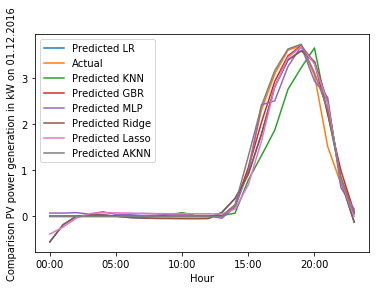

In [147]:
# Comparison PV
plt.plot(lr_pv_hat, label='Predicted LR')
plt.plot(y_test_pv.values, label='Actual')
plt.plot(y_pv_hat, label='Predicted KNN')
plt.plot(gbr_pv_hat, label='Predicted GBR')
plt.plot(m_pv_hat, label='Predicted MLP')
plt.plot(r_pv_hat, label='Predicted Ridge')
plt.plot(lasso_pv_hat, label='Predicted Lasso')
plt.plot(plot_values_pv, label='Predicted AKNN')
plt.ylabel('Comparison PV power generation in kW on 01.12.2016')
plt.xticks([0, 5, 10, 15, 20],
           ['00:00', '05:00', '10:00', '15:00', '20:00'])
plt.xlabel('Hour')
plt.legend()
plt.show()

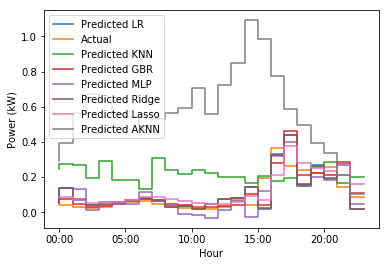

In [148]:
# Comparison Wind using step graph
plt.step(hour, lr_wind_hat, label='Predicted LR')
plt.step(hour, y_test_wind.values, label='Actual')
plt.step(hour, y_wind_hat, label='Predicted KNN')
plt.step(hour, gbr_wind_hat, label='Predicted GBR')
plt.step(hour, m_wind_hat, label='Predicted MLP')
plt.step(hour, r_wind_hat, label='Predicted Ridge')
plt.step(hour, lasso_wind_hat, label='Predicted Lasso')
plt.step(hour, plot_values_wind, label='Predicted AKNN')
plt.ylabel('Power (kW)')
plt.xticks([0, 5, 10, 15, 20],
           ['00:00', '05:00', '10:00', '15:00', '20:00'])
plt.xlabel('Hour')
plt.legend()
plt.show()

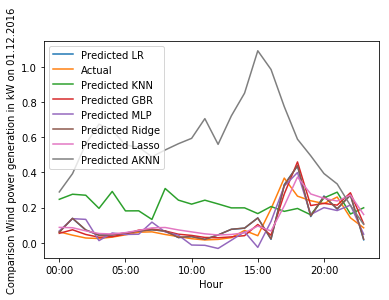

In [149]:
# Comparison Wind
plt.plot(lr_wind_hat, label='Predicted LR')
plt.plot(y_test_wind.values, label='Actual')
plt.plot(y_wind_hat, label='Predicted KNN')
plt.plot(gbr_wind_hat, label='Predicted GBR')
plt.plot(m_wind_hat, label='Predicted MLP')
plt.plot(r_wind_hat, label='Predicted Ridge')
plt.plot(lasso_wind_hat, label='Predicted Lasso')
plt.plot(plot_values_wind, label='Predicted AKNN')
plt.ylabel('Comparison Wind power generation in kW on 01.12.2016')
plt.xticks([0, 5, 10, 15, 20],
           ['00:00', '05:00', '10:00', '15:00', '20:00'])
plt.xlabel('Hour')
plt.legend()
plt.show()

In [150]:
# To create a csv file of forecast which can be used for optimization
date_time = ["Day"]
for a in time_last_day:
    date_time.append(a)

prediction_pv = ["PV power generation in kW"]
for a in plot_values_pv:
    prediction_pv.append(a)

# For wind MLP gave the best prediction based on lowest NRMSE. Hence we are using it.
prediction_wind = ["Wind power generation in kW"]
for a in m_wind_hat:
    prediction_wind.append(a)

zip_time_and_forecast = zip(date_time, prediction_pv, prediction_wind)
x = tuple(zip_time_and_forecast)
with open('result_gen_pv_wind.csv', 'w') as csvFile:
    for a in x:
        writer = csv.writer(csvFile)
        writer.writerow(a)